In [1]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
mpl.use('Agg') # run matplotlib without X server (GUI)
import matplotlib.pyplot as plt
%matplotlib inline

from Dataset import Dataset, saveDataset, loadDataset
from CNN_Model import CNN_Model, loadModel, saveModel
from ECOC_Classifier import ECOC_Classifier
from Stage import Stage
from Staged_Network import Staged_Network, saveStagedModel, loadStagedModel
from Utils import *

from localization_utilities import *
from main import *

from keras.models import Sequential, Graph, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.advanced_activations import PReLU

# Import Selective Search code
selsearch_root = '/home/lifelogging/code/selective_search'
import sys
sys.path.insert(0, selsearch_root)
import sel_search

import os
import logging
import copy
from operator import add
import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
from skimage.transform import resize

logging.basicConfig(level=logging.DEBUG, format='[%(asctime)s] %(message)s', datefmt='%d/%m/%Y %H:%M:%S')

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
/home/lifelogging/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Path to the produced evaluation measures
path_data = '/media/HDD_2TB/marc/FoodDetection_keras_Data/CAMs_test_combined'

# Load list of classes
path_classes = ['/media/HDD_2TB/DATASETS/UECFOOD256_recognition/classes.txt', \
                '/media/HDD_2TB/DATASETS/EgocentricFood_recognition/classes.txt']
classes = []
for ip, p in enumerate(path_classes):
    with open(p, 'r') as list_c:
        for il, line in enumerate(list_c):
            if(not (ip > 0 and il == 0)):
                line = line.rstrip('\n')
                line = line.rstrip('\r')
                classes.append(line)

## Data for Precision/Recall/Accuracy vs IoU curves

In [47]:
# Load all the necessary data (for Precision/Recall/Accuracy vs IoU curves)
pre = np.load(path_data+'/precisions_GAP.npy')
rec = np.load(path_data+'/recalls_GAP.npy')
acc = np.load(path_data+'/accuracies_GAP.npy')
nGT = np.load(path_data+'/num_GT_GAP.npy')
nPred = np.load(path_data+'/num_predictions_GAP.npy')

pre_c = np.load(path_data+'/precisions_classes_GAP.npy')
rec_c = np.load(path_data+'/recalls_classes_GAP.npy')
acc_c = np.load(path_data+'/accuracies_classes_GAP.npy')
nGT_c = np.load(path_data+'/num_GT_classes_GAP.npy')
nPred_c = np.load(path_data+'/num_predictions_classes_GAP.npy')


# [per_heat, size_res, box_exp, iou, n_bb] for each test
params = np.load(path_data+'/params_cross_val_GAP.npy')

# [predicted_bboxes, predicted_Y, predicted_scores, GT_bboxes, GT_Y] for each image
reports = np.load(path_data+'/reports_GAP.npy') 

##### Choose best combination of parameters

In [48]:
# Get test settings with best average recall when comparing all IoU thresholds
len_sequence_IoU = 6
valid = acc.shape[0]-acc.shape[0]%len_sequence_IoU

rec__ = np.reshape(acc[:valid], (valid/6,6))
best_ind = np.argmax(np.mean(rec__, axis=1))*6
print rec[best_ind:best_ind+len_sequence_IoU]
print best_ind

print "Best test position: " + str(best_ind)
print "Best recall: " +str(rec[best_ind])
print "Best precision: " +str(pre[best_ind])
print "Best accuracy: " +str(acc[best_ind])
print "Best params:" 
print "[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]"
print params[best_ind]

best_params = params[best_ind]

[ 0.54020833  0.49177083  0.39958333  0.235625    0.05958333  0.        ]
0
Best test position: 0
Best recall: 0.540208333333
Best precision: 0.805905205905
Best accuracy: 0.478016407042
Best params:
[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]
[  4.00000000e-01   1.00000000e-01   2.00000000e-01   5.00000000e-01
   9.99999000e+05]


## Data for Precision vs Recall curves

In [59]:
# Load all the necessary data (for Precision vs Recall curves)
fixedIoU = 0.5

pre = np.load(path_data+'/fixedIoU_'+str(fixedIoU)+'_precisions_GAP.npy')
rec = np.load(path_data+'/fixedIoU_'+str(fixedIoU)+'_recalls_GAP.npy')
pre_c = np.load(path_data+'/fixedIoU_'+str(fixedIoU)+'_precisions_classes_GAP.npy')
rec_c = np.load(path_data+'/fixedIoU_'+str(fixedIoU)+'_recalls_classes_GAP.npy')


# [per_heat, size_res, box_exp, iou, n_bb] for each test
params = np.load(path_data+'/params_cross_val_GAP.npy')

# [predicted_bboxes, predicted_Y, predicted_scores, GT_bboxes, GT_Y] for each image
reports = np.load(path_data+'/reports_GAP.npy') 

##### Choose combination of parameters given a fixedIoU

In [50]:
best_ind = None
for pos_p in range(len(params)):
    if params[pos_p][3] == fixedIoU:
        best_ind = pos_p
best_ind

0

# -------------------------------------------------------------------------------------------

## Use Selective Search for generating candidates

In [38]:
# Path to the produced evaluation measures
selpath_data = '/media/HDD_2TB/marc/FoodDetection_keras_Data/SelSearch_test_combined'

# Load all the necessary data
detect_type = 'SelSearch'

selprec = np.load(selpath_data+'/precisions_'+detect_type+'.npy')
selrec = np.load(selpath_data+'/recalls_'+detect_type+'.npy')
selacc = np.load(selpath_data+'/accuracies_'+detect_type+'.npy')
selnGT = np.load(selpath_data+'/num_GT_'+detect_type+'.npy')
selnPred = np.load(selpath_data+'/num_predictions_'+detect_type+'.npy')

selprec_c = np.load(selpath_data+'/precisions_classes_'+detect_type+'.npy')
selrec_c = np.load(selpath_data+'/recalls_classes_'+detect_type+'.npy')
selacc_c = np.load(selpath_data+'/accuracies_classes_'+detect_type+'.npy')
selnGT_c = np.load(selpath_data+'/num_GT_classes_'+detect_type+'.npy')
selnPred_c = np.load(selpath_data+'/num_predictions_classes_'+detect_type+'.npy')


# [per_heat, size_res, box_exp, iou, n_bb] for each test
selparams = np.load(selpath_data+'/params_cross_val_'+detect_type+'.npy')

# [predicted_bboxes, predicted_Y, predicted_scores, GT_bboxes, GT_Y] for each image
selreports = np.load(selpath_data+'/reports_'+detect_type+'.npy') 

In [39]:
print selnPred
selbest_ind = np.argmax(selacc)
print "Best test position: " + str(selbest_ind)
print "Best accuracy: " +str(selacc[selbest_ind])
print "Best precision: " +str(selprec[selbest_ind])
print "Best recall: " +str(selrec[selbest_ind])
print "Best params:" 
print "[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]"
print selparams[selbest_ind]

selbest_params = selparams[selbest_ind]
selbest_reports = selreports[selbest_ind]

[6005810 6005810 6005810 6005810 6005810 6005810]
Best test position: 0
Best accuracy: 0.0014787244811
Best precision: 0.00147890126394
Best recall: 0.925208333333
Best params:
[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   5.00000000e-01
   9.99999000e+05]


## Use Faster-RCNN for generating candidates

In [16]:
# Path to the produced evaluation measures
fastpath_data = '/media/HDD_2TB/marc/FoodDetection_keras_Data/FasterRCNN_test_combined'

# Load all the necessary data
detect_type = 'FasterRCNN'

fastprec = np.load(fastpath_data+'/precisions_'+detect_type+'.npy')
fastrec = np.load(fastpath_data+'/recalls_'+detect_type+'.npy')
fastacc = np.load(fastpath_data+'/accuracies_'+detect_type+'.npy')
fastnGT = np.load(fastpath_data+'/num_GT_'+detect_type+'.npy')
fastnPred = np.load(fastpath_data+'/num_predictions_'+detect_type+'.npy')

fastprec_c = np.load(fastpath_data+'/precisions_classes_'+detect_type+'.npy')
fastrec_c = np.load(fastpath_data+'/recalls_classes_'+detect_type+'.npy')
fastacc_c = np.load(fastpath_data+'/accuracies_classes_'+detect_type+'.npy')
fastnGT_c = np.load(fastpath_data+'/num_GT_classes_'+detect_type+'.npy')
fastnPred_c = np.load(fastpath_data+'/num_predictions_classes_'+detect_type+'.npy')


# [per_heat, size_res, box_exp, iou, n_bb] for each test
fastparams = np.load(fastpath_data+'/params_cross_val_'+detect_type+'.npy')

# [predicted_bboxes, predicted_Y, predicted_scores, GT_bboxes, GT_Y] for each image
fastreports = np.load(fastpath_data+'/reports_'+detect_type+'.npy') 

In [17]:
print fastnPred
fastbest_ind = np.argmax(fastacc)
print "Best test position: " + str(fastbest_ind)
print "Best accuracy: " +str(fastacc[fastbest_ind])
print "Best precision: " +str(fastprec[fastbest_ind])
print "Best recall: " +str(fastrec[fastbest_ind])
print "Best params:" 
print "[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]"
print fastparams[fastbest_ind]

fastbest_params = fastparams[fastbest_ind]
fastbest_reports = fastreports[fastbest_ind]

[95395 95395 95395 95395 95395 95395]
Best test position: 0
Best accuracy: 0.0713556866186
Best precision: 0.0733057288118
Best recall: 0.7284375
Best params:
[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   5.00000000e-01
   9.99999000e+05]


### Plot some examples

In [ ]:
#id_img = 2376
#windows = sel_search.get_windows([samples_detection['list_imgs'][id_img]])
#windows = np.load(selpath_data +'/'+ samples_detection['all_ids'][id_img] +'_windows.npy')

NameError: name 'reports' is not defined

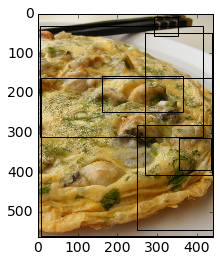

In [20]:
id_img = 2376
id_img = 185

im = misc.imread(samples_detection['list_imgs'][id_img])
ax = plt.subplot(1,1,1)
plt.imshow(im)

# Selective Search result
#### BEWERE! we are using stored reports instead of the last output
#selreport = selreports[selbest_ind]
#for box in selreport[id_img][0]:
#    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='red'))

# Faster-RCNN
#### BEWERE! we are using stored reports instead of the last output
fastreport = fastreports[fastbest_ind]
for box in fastreport[id_img][0]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='black'))
    
# FoodVsNoFood GoogleNet-GAP result
#### BEWERE! we are using stored reports instead of the last output
report = reports[best_ind]
print report[id_img]
for box in report[id_img][0]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
    
# Ground Truth
for box in report[id_img][3]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))

/media/HDD_2TB/DATASETS/UECFOOD256/1/15085.jpg


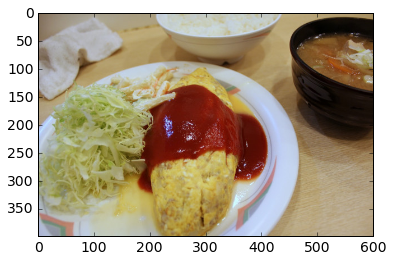

In [68]:
id_img = 1247

print samples_detection['list_imgs'][id_img]
im = misc.imread(samples_detection['list_imgs'][id_img])
ax = plt.subplot(1,1,1)
plt.imshow(im)

/media/HDD_2TB/DATASETS/UECFOOD256/13/1220.jpg
[[[52.899999999999999, 2.1999999999999993, 318.09999999999997, 227.79999999999998]], [13], [0.99852705], [[0.0, 24.0, 320.0, 220.0]], [13]]


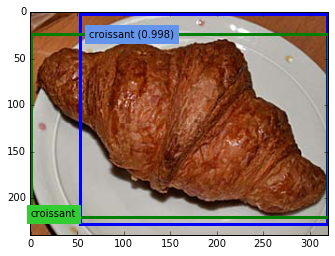

In [14]:
id_img = 483

print samples_detection['list_imgs'][id_img]
im = misc.imread(samples_detection['list_imgs'][id_img])
ax = plt.subplot(1,1,1)
plt.imshow(im)

# Selective Search result
#### BEWERE! we are using stored reports instead of the last output
#selreport = selreports[selbest_ind]
#for box in selreport[id_img][0]:
#    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3],-box[1] facecolor="none", edgecolor='red'))

# FoodVsNoFood GoogleNet-GAP result
print report_classes[id_img]
for box, y, prob in zip(report_classes[id_img][0], report_classes[id_img][1], report_classes[id_img][2]):
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
    ax.text(box[0]+10, box[1]+25, classes[y] + ' (' + str(prob)[:5] + ')', backgroundcolor='cornflowerblue')
    
# Ground Truth
for box, y in zip(report_classes[id_img][3], report_classes[id_img][4]):
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))
    ax.text(box[0], box[3], classes[y], backgroundcolor='limegreen')

1202
/media/HDD_2TB/DATASETS/UECFOOD256/5/14875.jpg
[[[288.19999999999999, 56.599999999999994, 639, 373.40000000000003]], [5], [0.74239528], [[340.0, 98.0, 640.0, 362.0], [28.0, 127.0, 423.0, 561.0]], [5, 112]]
1203
/media/HDD_2TB/DATASETS/UECFOOD256/1/14880.jpg
[[[1.5, 0, 639, 458.39999999999998]], [96], [0.62054372], [[420.0, 22.0, 608.0, 202.0], [0.0, 48.0, 368.0, 444.0]], [1, 20]]
1205
/media/HDD_2TB/DATASETS/UECFOOD256/1/14885.jpg
[[[0, 9.0999999999999943, 799, 583.90000000000009]], [108], [0.11351695], [[56.0, 235.0, 336.0, 483.0], [545.0, 250.0, 780.0, 483.0]], [1, 36]]
1206
/media/HDD_2TB/DATASETS/UECFOOD256/1/14887.jpg
[[[72.5, 13.899999999999999, 639, 375.09999999999997]], [118], [0.11969403], [[0.0, 241.0, 208.0, 468.0], [437.0, 15.0, 613.0, 188.0]], [1, 36]]
1207
/media/HDD_2TB/DATASETS/UECFOOD256/1/14890.jpg
[[[0, 11.899999999999999, 799, 553.10000000000002]], [96], [0.75509971], [[390.0, 311.0, 661.0, 561.0], [363.0, 13.0, 611.0, 231.0], [45.0, 186.0, 365.0, 355.0], [81.0

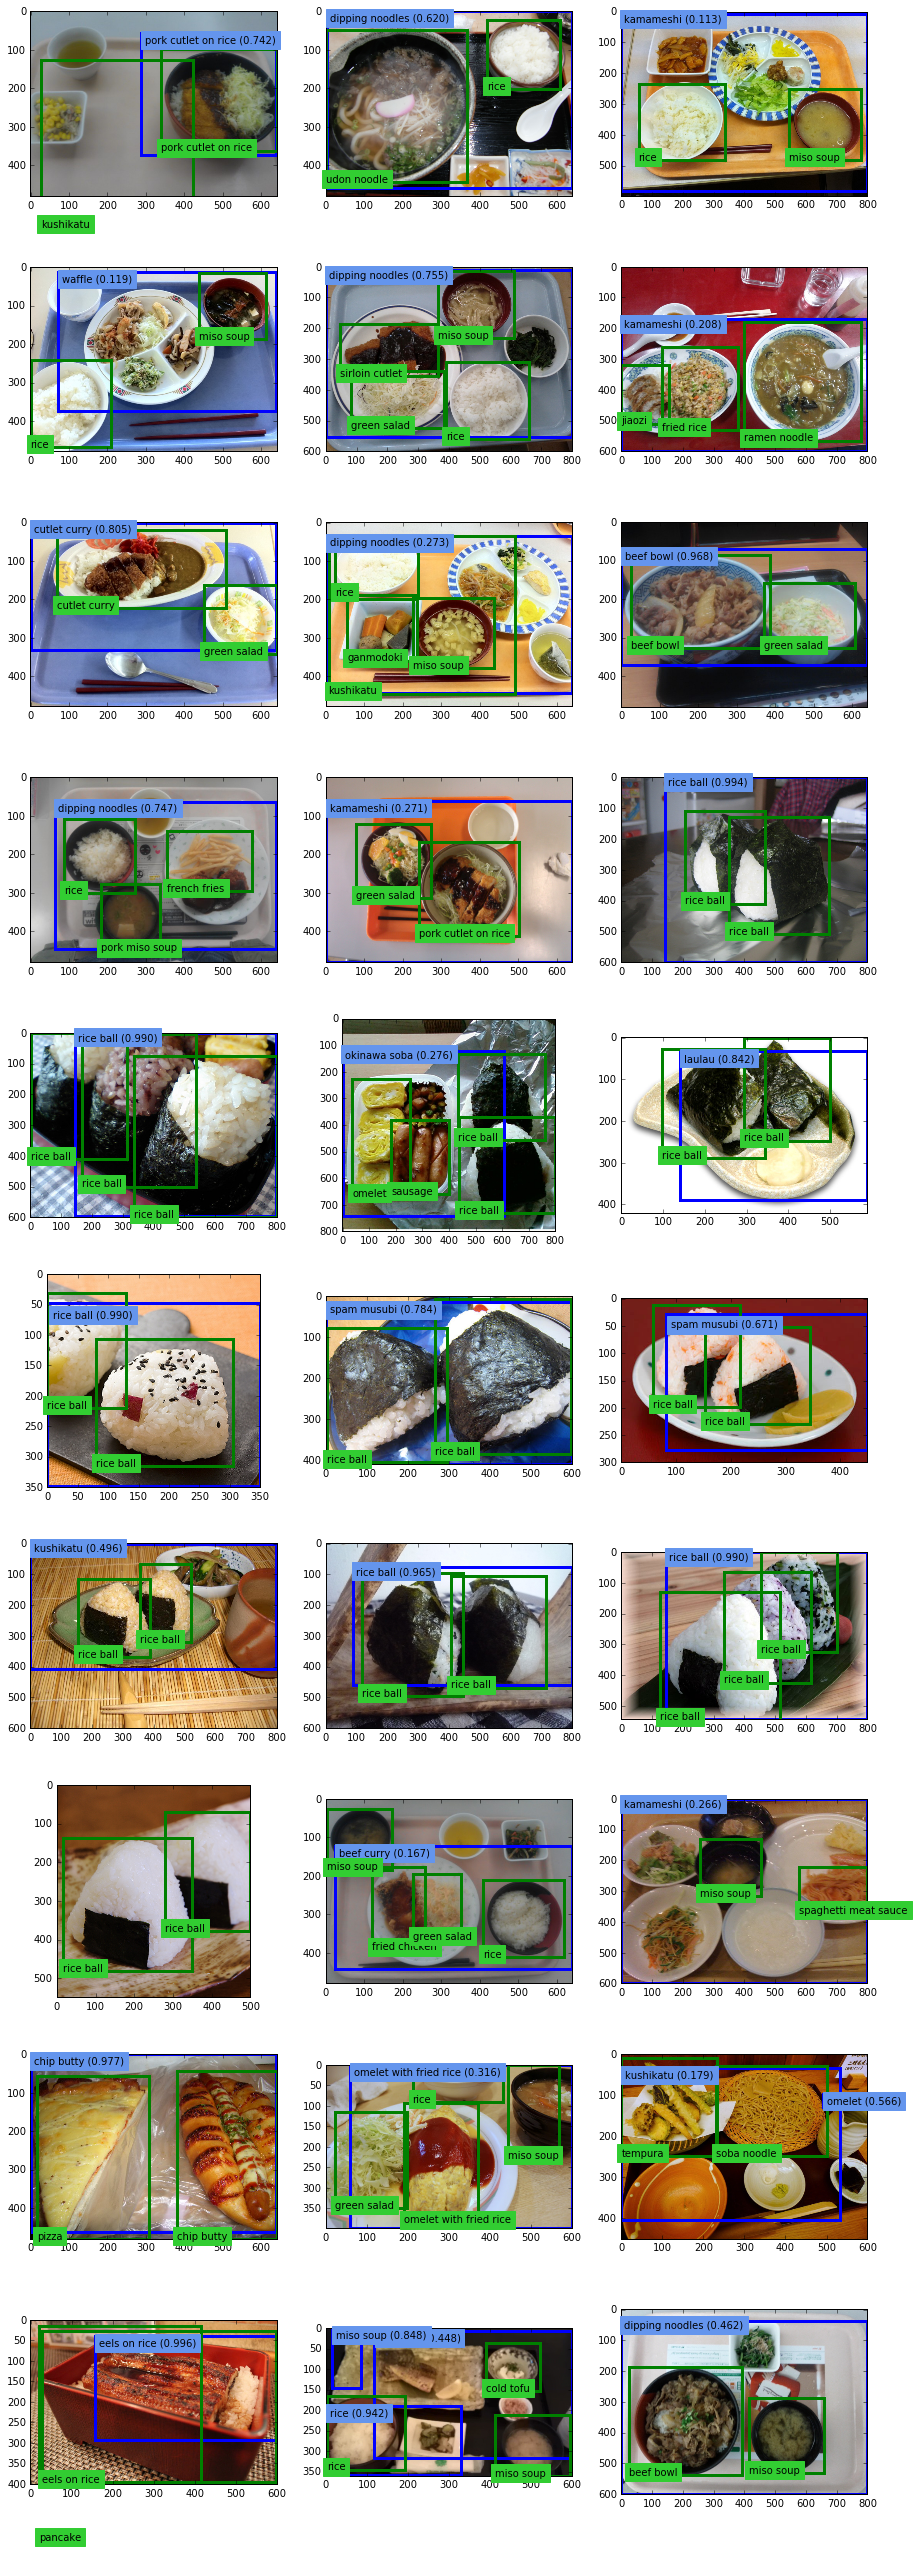

In [49]:
id_img = 1202
found = 0

f = plt.figure(1)
f.set_size_inches(15, 15*3)
while(found < 30):
    if(len(report_classes[id_img][4])) > 1:
        found += 1
        print id_img
        print samples_detection['list_imgs'][id_img]
        im = misc.imread(samples_detection['list_imgs'][id_img])
        ax = plt.subplot(10,3,found)
        plt.imshow(im)

        # Selective Search result
        #### BEWERE! we are using stored reports instead of the last output
        #selreport = selreports[selbest_ind]
        #for box in selreport[id_img][0]:
        #    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3],-box[1] facecolor="none", edgecolor='red'))

        # FoodVsNoFood GoogleNet-GAP result
        print report_classes[id_img]
        for box, y, prob in zip(report_classes[id_img][0], report_classes[id_img][1], report_classes[id_img][2]):
            ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
            ax.text(box[0]+10, box[1]+25, classes[y] + ' (' + str(prob)[:5] + ')', backgroundcolor='cornflowerblue')

        # Ground Truth
        for box, y in zip(report_classes[id_img][3], report_classes[id_img][4]):
            ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))
            ax.text(box[0], box[3], classes[y], backgroundcolor='limegreen')
        
    id_img += 1

## Plot Recall/Precision/Accuracy vs IoU

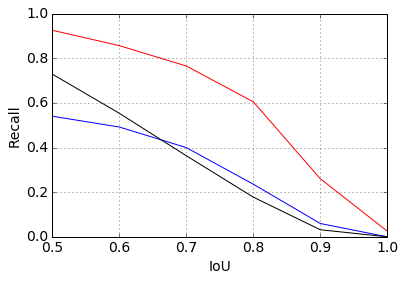

In [41]:
sequence = [best_ind, best_ind+6]
selsequence = [selbest_ind, selbest_ind+6]
fastsequence = [fastbest_ind, fastbest_ind+6]

# Plot data
#plt.plot([l[1] for l in list_measures], color='blue')
plt.plot(rec[sequence[0]:sequence[1]], color='blue')
plt.plot(selrec[selsequence[0]:selsequence[1]], color='red')
plt.plot(fastrec[fastsequence[0]:fastsequence[1]], color='black')
plt.grid()

# Set Y labels
plt.ylabel('Recall')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')


font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

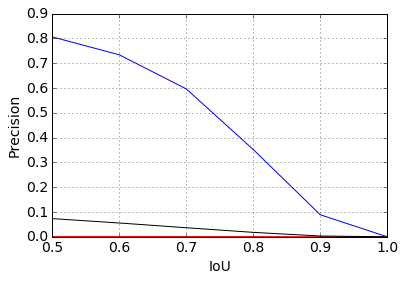

In [42]:
# Plot data
#plt.plot([l[0] for l in list_measures], color='blue')
plt.plot(pre[sequence[0]:sequence[1]], color='blue')
plt.plot(selprec[selsequence[0]:selsequence[1]], color='red')
plt.plot(fastprec[fastsequence[0]:fastsequence[1]], color='black')
plt.grid()

# Set Y labels
plt.ylabel('Precision')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

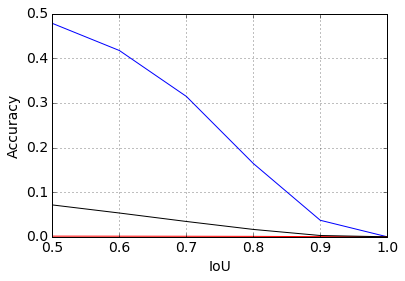

In [43]:
# Plot data
#plt.plot([l[2] for l in list_measures], color='blue')
plt.plot(acc[sequence[0]:sequence[1]], color='blue')
plt.plot(selacc[selsequence[0]:selsequence[1]], color='red')
plt.plot(fastacc[fastsequence[0]:fastsequence[1]], color='black')
plt.grid()

# Set Y labels
plt.ylabel('Accuracy')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

## Detection methods time comparison (including image loading): SelSearch 0.8s per image, Faster-RCNN 0.2s per image, GAP 0.06s per image

In [34]:
print np.mean(pre_c[best_ind,1:]) # precision
print np.mean(rec_c[best_ind,1:]) # recall
print np.mean(acc_c[best_ind,1:]) # accuracy
print
print "no food included:"
print np.mean(pre_c[best_ind,0:]) # precision
print np.mean(rec_c[best_ind,0:]) # recall
print np.mean(acc_c[best_ind,0:]) # accuracy

0.535809561137
0.492642342917
0.358195745335

no food included:
0.536144863539
0.49107655265
0.357122887398


## Plot Precision vs Recall curves

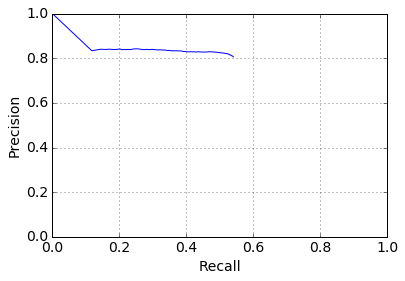

In [61]:
# all? variables to plot: pre, rec, prec_c, rec_c

pre[-1]=1.0

# Plot data
#plt.plot([1.]+list(rec), [0.]+list(pre), color='blue')
plt.plot(list(rec), list(pre), color='blue')

#plt.plot(selrec[selsequence[0]:selsequence[1]], color='red')
#plt.plot(fastrec[fastsequence[0]:fastsequence[1]], color='black')
plt.grid()

# Set labels
plt.ylabel('Precision')
plt.xlabel('Recall')

axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])


font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

In [52]:
print pre
print rec

[ 0.80590521  0.80590521  0.80590521  0.80590521  0.80590521  0.80590521
  0.80590521  0.80590521  0.80590521  0.80590521  0.80590521  0.80637636
  0.80706945  0.80792635  0.8084441   0.80927754  0.80973312  0.8109343
  0.81160107  0.81253968  0.81428344  0.8156505   0.8158868   0.8179317
  0.81946931  0.81996727  0.82123457  0.82167716  0.82249708  0.82349975
  0.82372881  0.82453443  0.82517241  0.82591304  0.82687927  0.82746417
  0.82793776  0.8284013   0.82869106  0.82916053  0.82881545  0.82770904
  0.82787351  0.82771822  0.82789433  0.82854896  0.8291617   0.82780792
  0.82864711  0.82876006  0.8292581   0.82866836  0.8288908   0.830024
  0.83045595  0.83184057  0.83265491  0.83276217  0.83329474  0.83341143
  0.83353123  0.83305268  0.83353614  0.83436341  0.83504638  0.83502796
  0.83607823  0.83676126  0.83684765  0.83702321  0.8376921   0.83797814
  0.83697154  0.83796686  0.83826038  0.838812    0.83967232  0.83914209
  0.8383869   0.83986424  0.83896185  0.83854499  0.838

In [27]:
[0]+list(pre[dataset])+[1]

[0,
 0.85870848086326079,
 0.85870848086326079,
 0.86930143872421561,
 0.88326848249027234,
 0.89423076923076927,
 0.90200186219739298,
 0.91217298451681794,
 0.92350061199510403,
 0.93254395407247936,
 0.94039431453461719,
 1]